### User Input

In [1]:

# MODEL PARAMETERS
model_settings ={
    'layers': 5,
    'dropout': 0.1,
    'padding': 'same',
    'n_models': 16
}

mfccs_json_path = "../mfccs_cnn_humpbackwhale_walrus_killerwhale_bowheadwhale_fin_finbackwhale_emptyocean.json"

csv_file_name = '../model-stats/layers-' + str(model_settings['layers']) + '_n-models-' + str(model_settings['n_models']) + '.csv'

plot_file_name = '../images/layers-' + str(model_settings['layers']) + '_filters-1-' + str(model_settings['n_models']) + '.png'

### Imports

In [16]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import warnings

import glob
import os

from cnn_comparison_lib import save_mfcc

### Load MFCC Dataset

In [3]:
from cnn_comparison_lib import load_cnn_json

X, y, L = load_cnn_json(mfccs_json_path)
print(f"mapping the marine mammals: {L}")
# Check class counts and that labels are numerical order
np.unique(y, return_counts=True)

mapping the marine mammals: ['BowheadWhale' 'EmptyOcean' 'Fin_FinbackWhale' 'HumpbackWhale'
 'KillerWhale' 'Walrus']


(array([1, 2, 3, 4, 5, 6]),
 array([1000, 1000, 1000, 1000, 1000, 1000], dtype=int64))

### Create Training, Validation, and Test Sets

In [4]:
# create train, validation and test sets
from cnn_comparison_lib import prepare_datasets

X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(X, y, 0.6, 0.5) # test size, vailidation size
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

### Build the 3-Layer Models

In [5]:
from cnn_comparison_lib import create_layered_cnn

L3_model_list = []
for i in range(model_settings['n_models']):
    output_shape = i + 1
    model = create_layered_cnn(model_settings['layers'], input_shape, output_shape, model_settings)
    L3_model_list.append(model)

### Get 3-Layer Trainable Parameter Count

In [6]:
from cnn_comparison_lib import count_trainable_parameters

L3_parameter_count = []
for model in L3_model_list:
    count = count_trainable_parameters(model)
    L3_parameter_count.append(count)

print(L3_parameter_count)

[23749, 46921, 70165, 93481, 116869, 140329, 163861, 187465, 211141, 234889, 258709, 282601, 306565, 330601, 354709, 378889]


### Train the 3-Layer Models

In [7]:
from cnn_comparison_lib import plot_history

L3_history = []
for model in L3_model_list:
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=16, epochs=5)
    L3_history.append(history)

Epoch 1/5
75/75 [==============================] - 4s 38ms/step - loss: 2.2883 - accuracy: 0.2042 - val_loss: 2.1069 - val_accuracy: 0.2742
Epoch 2/5
75/75 [==============================] - 3s 36ms/step - loss: 1.6336 - accuracy: 0.4383 - val_loss: 1.9239 - val_accuracy: 0.2967
Epoch 3/5
75/75 [==============================] - 3s 34ms/step - loss: 1.4242 - accuracy: 0.4950 - val_loss: 1.7285 - val_accuracy: 0.4058
Epoch 4/5
75/75 [==============================] - 2s 33ms/step - loss: 1.3552 - accuracy: 0.4958 - val_loss: 1.5312 - val_accuracy: 0.5200
Epoch 5/5
75/75 [==============================] - 2s 33ms/step - loss: 1.2885 - accuracy: 0.5042 - val_loss: 1.3508 - val_accuracy: 0.5225
Epoch 1/5
75/75 [==============================] - 4s 40ms/step - loss: 1.8103 - accuracy: 0.3167 - val_loss: 1.8551 - val_accuracy: 0.3667
Epoch 2/5
75/75 [==============================] - 3s 38ms/step - loss: 1.4172 - accuracy: 0.4283 - val_loss: 1.5098 - val_accuracy: 0.3942
Epoch 3/5
75/75 [===

### Evaluate the 3-Layer Models

In [8]:
# evaluate the cnn on the test set
L3_accuracy = []
for model in L3_model_list:
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    L3_accuracy.append(test_accuracy)

113/113 [==============================] - 2s 18ms/step - loss: 0.0937 - accuracy: 0.9733


### Plot the 3-Layer Models

Text(0, 0.5, 'Model Accuracy')

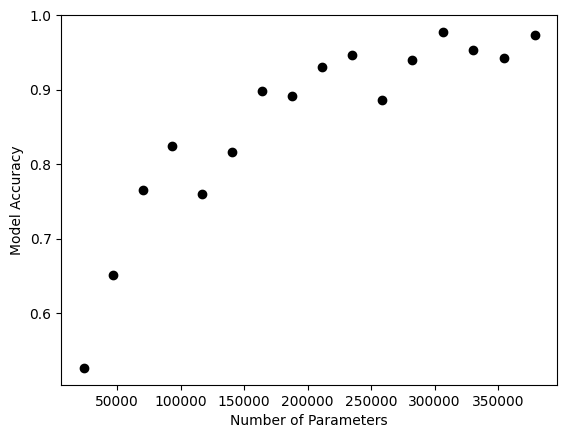

In [9]:
x = L3_parameter_count
y = L3_accuracy
plt.plot(x, y, 'o', color='black')
plt.xlabel("Number of Parameters")
plt.ylabel("Model Accuracy")

### Confusion Matrix

In [10]:
# iterate each sample of X_test, predict, and store predicted index into a numpy array.
ypred_array = np.array([])
model
for model1 in L3_model_list:
    model = model1

for i in range(len(X_test)):
    X = X_test[i]
    X = X[np.newaxis, ...] # to make a 4D
    
    # prediction
    prediction = model.predict(X)
    
    # extract the index with the max value
    predicted_index = np.argmax(prediction, axis=1)
    ypred_array = np.append(ypred_array, predicted_index)



1/1 [==============================] - 0s 18ms/step


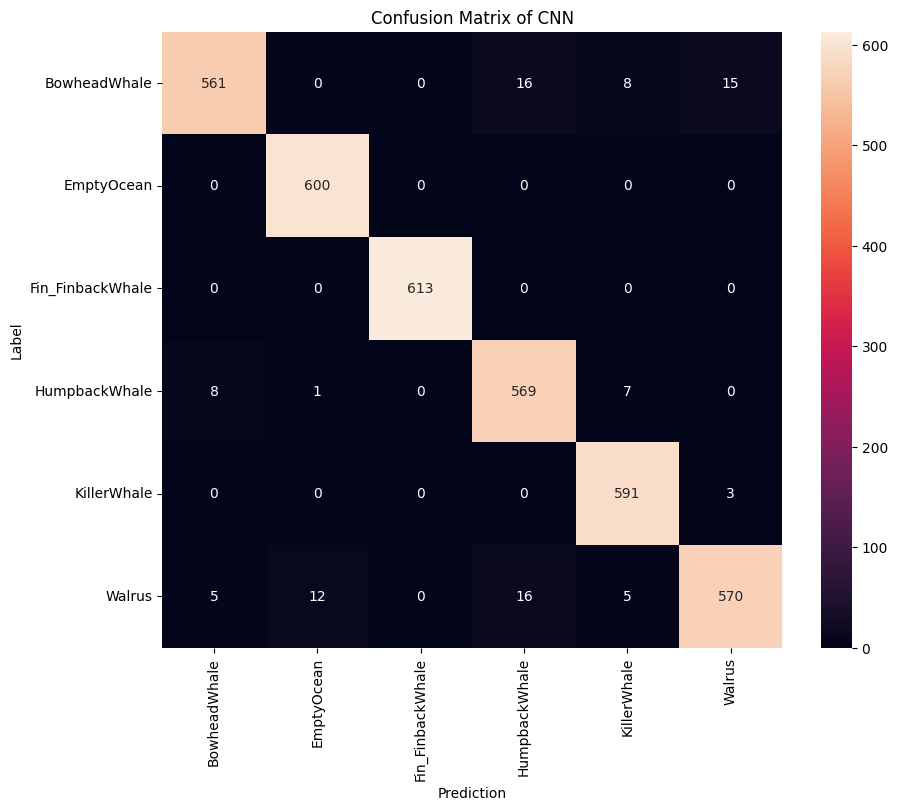

In [11]:
confusion_mtx = tf.math.confusion_matrix(y_test, ypred_array) 
num_rows = confusion_mtx.get_shape().as_list()[0] # we need these to remove (slice)
num_cols = confusion_mtx.get_shape().as_list()[1]
confusion_mtx= tf.slice(confusion_mtx, [1,1], [num_rows-1, num_cols-1])

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=L, yticklabels=L, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion Matrix of CNN")
plt.show()

### Save the models

In [12]:
# count = 1
# for model in L3_model_list:
#     model.save("syd_saved_models/empty_ocean/cnn_model_6_classes_dropout_01_"+str(count))
#     count = count + 1

### Gradio GUI

In [35]:
# trying to test getting the model to predict something (can delete this cell after, it's not needed for the GUI)
# This logic is meant for predict() function for gradio
model_1 = L3_model_list[1]

audio_path="../data_augmented_demo/"
json_path="../mfccs_demo.json"
save_mfcc(audio_path, json_path)
X, y, L = load_cnn_json(json_path)
X = X[np.newaxis, ...]
# DO WE NEED THE X_TEST PART??
# test_error, test_accuracy = model.evaluate(X, y, verbose=1)


Processing KillerWhale
../data_augmented_demo/KillerWhale\KillerWhale_aug_0.wav, segment:1
../data_augmented_demo/KillerWhale\KillerWhale_aug_0.wav, segment:2
../data_augmented_demo/KillerWhale\KillerWhale_aug_0.wav, segment:3
../data_augmented_demo/KillerWhale\KillerWhale_aug_0.wav, segment:4
../data_augmented_demo/KillerWhale\KillerWhale_aug_0.wav, segment:5


In [14]:
# import gradio as gr

# def predict(audio):
#     return "Demo"

# demo = gr.Interface(fn=predict, inputs=gr.Audio(value="../data_augmented_demo/KillerWhale_aug_0.wav"), outputs="text")

# demo.launch(share=True) 